In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
import time
import torch.nn as nn

In [2]:
torch.manual_seed(42)
np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 2
DATASET_CLUSTER_COUNT = 5
DATASET_R = 20

In [3]:
from cluster_tools import kmeans_elbow, ClusterSampler

Samplers

In [4]:
from torch import nn

LAMBDA = 1e-7

class LogisticLossModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=False)
        self.layer.weight.data.fill_(3)
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.log(1 + torch.exp(x))
        return res.flatten()
    
    def forward(self, ai):
        x = self.layer(ai)
        res = torch.pow(x - 1, 2)/2
        return res.flatten() + LAMBDA*self.layer.weight.norm()

def regress_criterion(output, batch):
    return output.mean()

In [70]:
from sklearn.datasets import make_blobs
clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                              n_features=DATASET_DIM,
                              centers=DATASET_CLUSTER_COUNT,
                              random_state=42)

clustered_data = torch.from_numpy(clustered_data.astype(np.float32))
labels = torch.zeros(DATASET_SIZE)

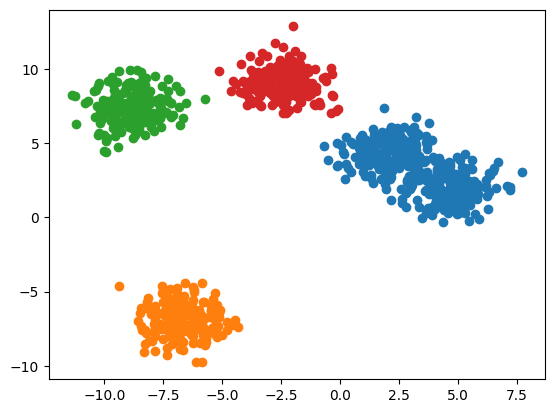

In [48]:
sampler = ClusterSampler(clustered_data, 64)
for i in range(sampler.cluster_count):
    selected = clustered_data[sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
plt.show()

Displaying what the clusters look like after evaluating the gradients

Solvers

In [49]:
# finding an exact solution

from tqdm import tqdm

model = LogisticLossModel(clustered_data)

n_epoch = 10000
losses = np.zeros(n_epoch)
lr = 0.001

for i in tqdm(range(n_epoch)):
    model.zero_grad()
    output = model(clustered_data)
    loss = regress_criterion(output, "")
    loss.backward()
    for p in model.parameters():
        p.data.sub_(lr*p.grad.data)
    losses[i] = loss.item()

opt_val = losses[-1]
opt_val

100%|██████████| 10000/10000 [00:03<00:00, 2583.49it/s]


0.3219119906425476

In [50]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [51]:
from utils import clone_model

In [52]:
NB_EPOCH = None
TIME_LIM = 10
BATCH_SIZE = 64

In [11]:
base_model = LogisticLossModel(clustered_data)

In [ ]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(clustered_data, labels)

In [ ]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader((clustered_data), BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM)

  1%|          | 575/100000 [00:10<28:51, 57.43it/s]


In [ ]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=0.0001)

  0%|          | 26/100000 [00:10<10:59:50,  2.53it/s]


In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=10,
                     learning_rate=0.01)

  0%|          | 14/100000 [00:10<20:38:28,  1.35it/s]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data), shuffle=True),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True)

Building models...


  3%|▎         | 2624/100000 [00:09<06:11, 262.46it/s]


In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM)

  0%|          | 13/100000 [00:10<22:41:18,  1.22it/s]


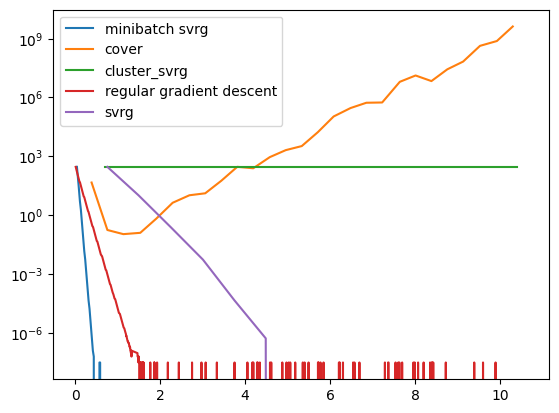

In [17]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [18]:
from utils import clone_model

In [ ]:
sgd_time, sgd_sol, opt_model = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 805/100000 [00:10<20:32, 80.47it/s]


In [ ]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True)

Building models...


  1%|          | 730/100000 [00:10<22:40, 72.99it/s]


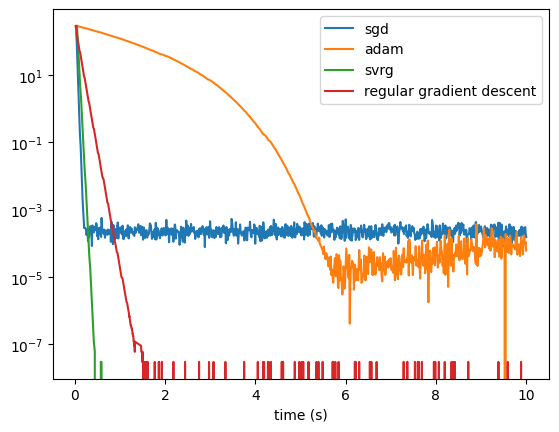

In [21]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [ ]:
iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

(tensor([5.0201, 2.5838]), tensor(0.))

In [ ]:
cluster_sampler = ClusterSampler(dataset, BATCH_SIZE)
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

In [39]:
sgd_iid_time, sgd_sol_iid, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=iid_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=1,
              verbose=True)

sgd_cluster_time, sgd_sol_cluster, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.SGD,
              dataloader=cluster_dataloader,
              n_epoch=NB_EPOCH,
              time_lim=1,
              verbose=True)

Building models...


  0%|          | 75/100000 [00:01<22:23, 74.35it/s]


Building models...


  0%|          | 81/100000 [00:01<20:43, 80.38it/s]


In [ ]:
from solvers import weighted_solver
sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    torch.optim.SGD,
    dataset,
    n_iter=None,
    time_lim=TIME_LIM,
    verbose=True
)

Building models...


UnboundLocalError: local variable 'n' referenced before assignment

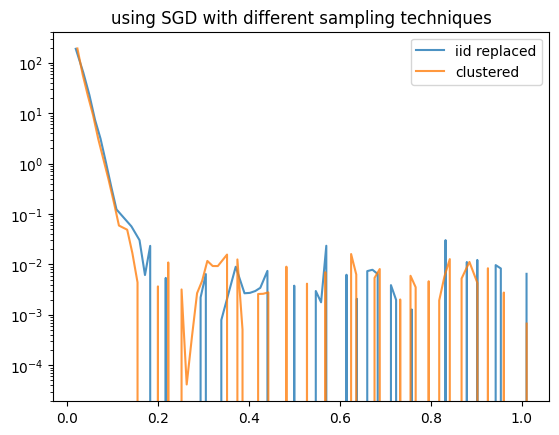

In [41]:
# plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)
plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
# plt.plot(sgd_alt_cluster_t, sgd_alt_cluster-opt_val, label="one per cluster", alpha=0.8)
plt.legend()
plt.yscale("log")
plt.title("using SGD with different sampling techniques")
plt.show()

In [ ]:
def get_grad(batch, model):
    ret = np.zeros((len(batch), 2))
    for i, elem in enumerate(batch):
        res = model(elem)
        l = regress_criterion(res, "")
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

def display_grads(dataset, model, title=""):
    dataset_torch = torch.from_numpy(dataset)
    for i in range(sampler.cluster_count):
        selected = dataset_torch[sampler.clusters[i]]
        grad_selected = get_grad(selected, model)
        plt.scatter(grad_selected[:,0], grad_selected[:,1], alpha=0.5)

    plt.title(title)
    plt.show()

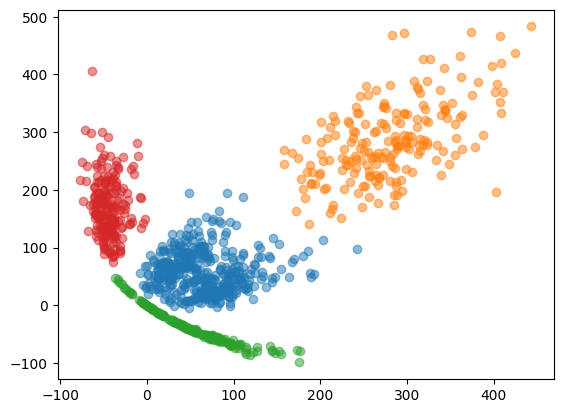

In [ ]:
display_grads(clustered_data, base_model)

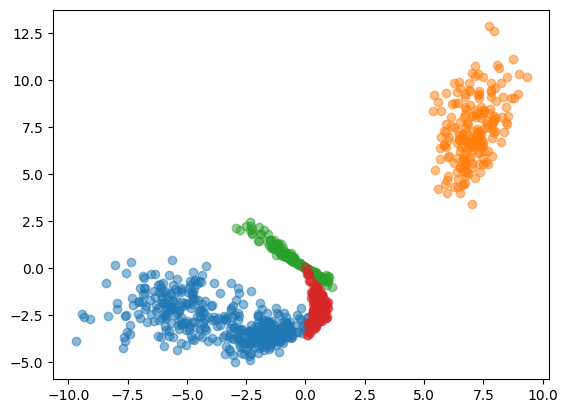

In [ ]:
display_grads(clustered_data, opt_model)

In [33]:
print(opt_model.layer.weight)

Parameter containing:
tensor([[-0.0605,  0.0687]], requires_grad=True)
